### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 2: Filtrado de señales

## Introducción


Un **electrocardiograma (ECG)** es un gráfico de voltaje (amplitud) en función del tiempo correspondiente a la actividad eléctrica del corazón. Cada etapa del ciclo cardíaco es representado por una letra: **P, Q, R, S y T**. La siguiente figura muestra un esquema de un ECG con dos pulsos.

<img src="cardio.png" width="600">


El ECG se usa para hacer diagnósticos y en particular para analizar la existencia de anormalidades en el ciclo cardiaco. La **frecuencia cardiaca**, es decir el inverso del intervalo RR, de un humano normal en reposo está en el rango de **60 y 100 latidos por minuto**



## Enunciado

El hospital base de Valdivia tiene un electrocardiógrafo que mide la ECG en miliVolts [mV] a una frecuencia de muestreo de $360$ [Hz]

Durante el proceso de captura ciertos errores provocaron que la señal se contamine con 

- **(A)** Un ruido asociado al sistema eléctrico
- **(B)** Un ruido de baja frecuencia causado por un desperfecto del sensor
- **(C)** Un ruido blanco de origen térmico 

Esto complica el análisis del médico por lo que el hospital base los contrata a ustedes para **diseñar un filtro que limpie la señal ECG**

Resuelva las actividades que se piden a continuación, respondiendo y analizando donde corresponda

<IPython.core.display.Javascript object>


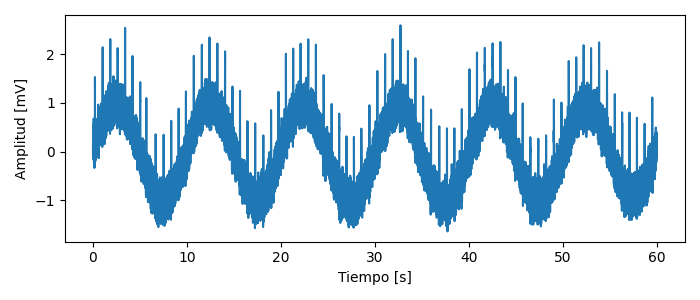

In [2]:
import numpy as np
import pickle
%matplotlib notebook
import matplotlib.pylab as plt

with open("ECG.pkl", "rb") as f:
    data = pickle.load(f)

Fs = 360
time = np.arange(len(data))/Fs
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [mV]');

## Análisis (15%)

- Observe los primeros dos segundos de la señal, compare con el esquema mostrado en la introducción y discuta sobre los efectos causados por los ruidos **A**, **B** y **C** mencionados en el enunciado. Además responda  ¿Qué es un ruido blanco y que tipo de efecto introduce en la señal y en su espectro? ¿Qué es una tendencia y que tipo de efecto introduce en la señal y su espectro? 
- Calcule y muestre gráficamente el valor absoluto de la transformada de Fourier de la señal en función de la frecuencia y su espectrograma en función del tiempo y la frecuencia. Para el espectrograma decida el largo de ventana, traslape y tipo de ventana. Justifique su elección tomando en consideración el rango de frecuencias de un paciente normal y los *trade-off* aprendidos en clases
- En base a la señal, su espectro de magnitud y su espectrograma identifique la frecuencia central o el rango de frecuencias asociada a las tres fuentes de ruido. ¿En qué rango de frecuencias (Hz) se espera encontrar la señal de ritmo cardíaco de un humano normal en reposo?


## Filtrado FIR (50%)

Describa lo que es un filtro FIR, explique paso a paso el método de enventanado y describa los argumentos y el valor de retorno de la función `scipy.signal.firwin`. 

Luego use este método para diseñar y aplicar tres filtros sobre la señal de entrada. El primero debe filtrar el ruido **(A)**, el segundo el ruido **(B)** y el tercero el ruido **(C)**. Indique la(s) frecuencia(s) de corte y el tipo de filtro en cada caso. Justifique su elección en base a sus observaciones en el paso anterior.

Considere una ventana de Hamming y $1001$ coeficientes para el filtro

Por cada filtro:
- Muestre la respuesta al impulso y la respuesta en frecuencia resultantes
- Filtre la señal convolucionando con la respuesta al impulso
- Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada. En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

Finalmente
- Filtre la señal convolucionando con los tres filtros. Muestre el resultado graficamente. 
- Muestre un acercamiento de los primeros tres segundos de la señal filtrada, reconozca la fase R y márquela con una linea roja punteada.
- Cree una función que mida el tiempo RR en la señal filtrada. Grafique la frecuencia cardiaca en función del tiempo. ¿Se encuentra la persona en el rango sano o no?

## Filtrado IIR (35%)

Describa los filtros IIR y compárelo con los filtros FIR. Describa los argumentos y el valor de retorno de la función `scipy.signal.iirfilter`.

Luego use este método para diseñar tres filtros. Los filtros deben cumplir el mismo propósito que en el caso anterior. Considere filtros IIR de tipo `butterworth` y todos del mismo orden. Aplique los filtros sobre la señal de entrada usando la función `scipy.signal.lfilter`.

El objetivo es encontrar el mínimo orden para los filtros IIR tal que el error medio cuadrático entre la señal filtrada IIR y la señal filtrada FIR sea menor que un 1% de la varianza de la señal filtrada FIR. Es decir que si $x$ es la señal filtrada IIR e $y$ es la señal filtrada FIR donde $N = \min(\text{len}(x), \text{len}(y))$ se cumpla que

$$
\sum_{i=1}^N (x_i - y_i)^2 < 0.01 \sum_{i=1}^N (y_i - \bar y_i)^2
$$

Finalmente, discuta sobre sus hallazgos muestre gráficamente el resultado del mejor filtro IIR


# Solución

## Análisis

### Fragmento de la señal


<IPython.core.display.Javascript object>


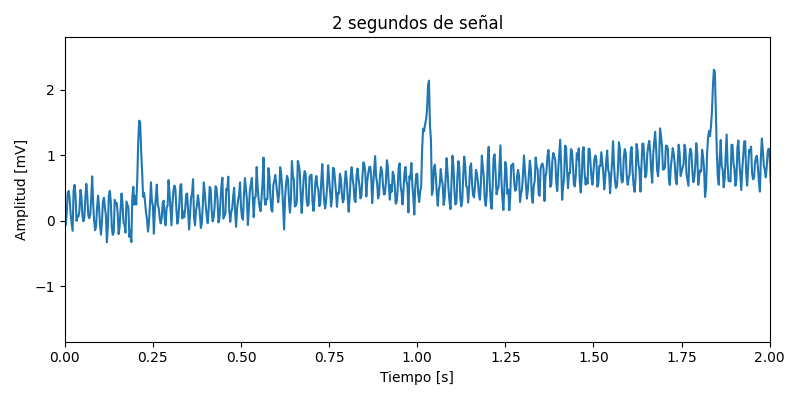

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as sfft
import scipy.signal
from IPython.display import Image, Audio
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
Fs = 360
time = np.arange(len(data))/Fs
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]');
ax.set_ylabel('Amplitud [mV]');
ax.set_xlim(0,2);
ax.set_title('2 segundos de señal');


<img src="cardio.png" width="600">

- Al comparar los dos segundos de la señal proporcionada por el hospital con la imagen mostrada en la introducción, podemos diferenciar la etapa Q, R y S del ciclo cardiaco, donde R será la que tenga mas amplitud, Q el inicio de esta y S el final. También se observa que el ciclo RR tiene un período de 0.8 segundos aproximadamente, por lo cual podemos decir que el corazón hace alrededor de 75 latidos por minutos, estando en el rango de un humano normal. Por otro lado, los ruidos **A**, **B** y **C** que se encuentran en este sistema no nos permiten detectar la etapa P y T, ya que los ruidos mencionados anteriormente perturban nuestra señal, por lo que será necesario implementar filtros para disminuir este ruido.  

- El ruido blanco es una señal no correlativa, contiene todas las frecuencias posibles, por lo que su presencia enmascara cualquier otra señal que exista. Podemos apreciar la existencia de este ruido en nuestra señal, ya que nos impide identificar claramente las etapas del ciclo cardiaco en el electrocardiograma.

- Una tendencia tendencia es un patrón de comportamiento de los elementos de un entorno particular durante un período. En una señal estas pueden dificultar el análisis de los datos, ya que la señal puede mostrar patrones generales que no son propios de ellos.

### Transformada de Furier y espectrograma

<IPython.core.display.Javascript object>


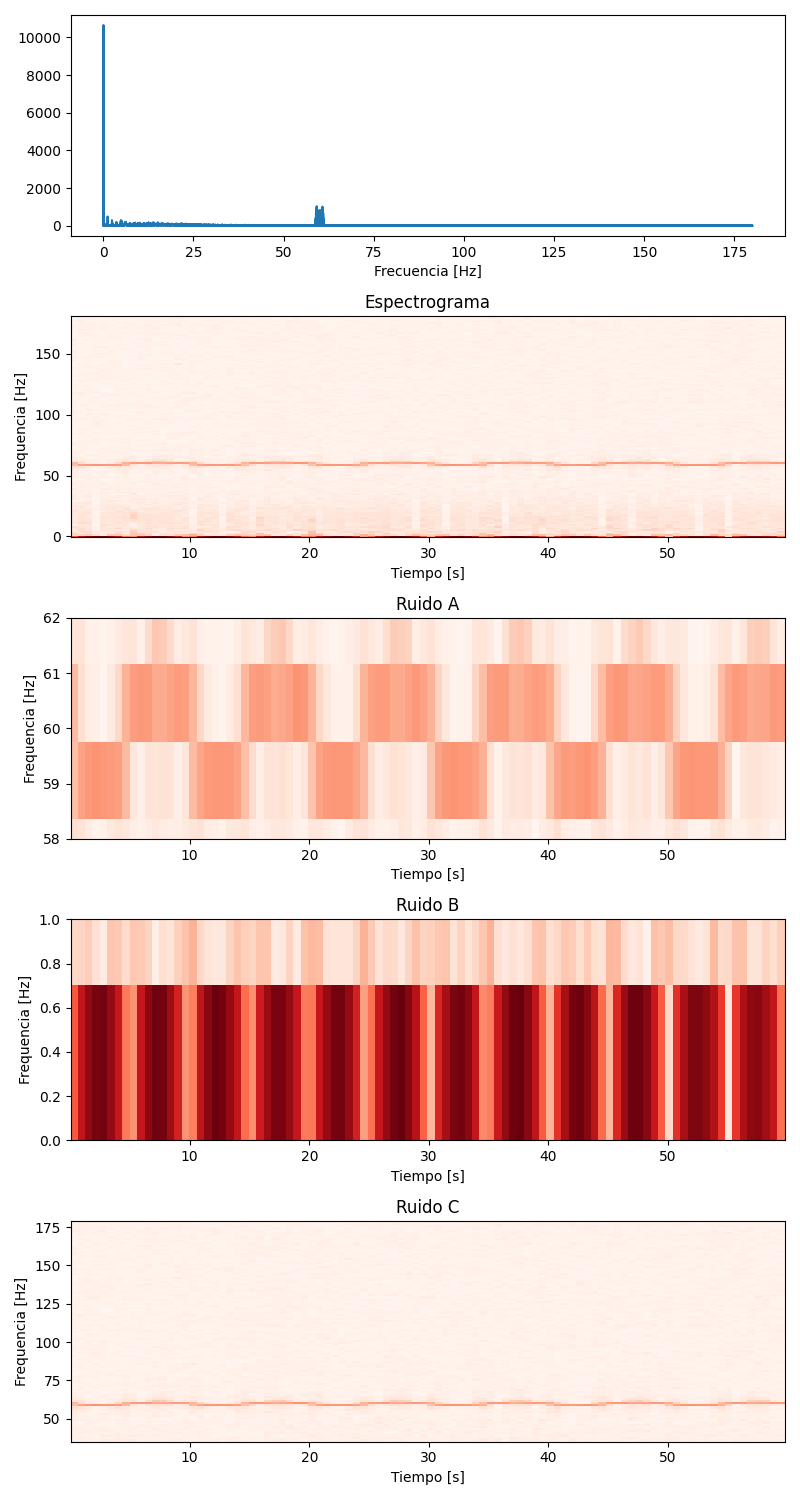

In [3]:
fig, ax = plt.subplots(5,figsize=(8, 15), tight_layout=True)
freq = sfft.rfftfreq(n=len(data), d=1./Fs)
S = np.absolute(sfft.rfft(data))
Nw = 256
freqs, times, Sxx = scipy.signal.spectrogram(data,
                                             fs=Fs,
                                             nperseg=Nw,
                                             noverlap=None,
                                             return_onesided=True,
                                             detrend=False,
                                             mode = 'magnitude',
                                             window=('rectangular'))
ax[0].plot(freq, S); 
ax[0].set_xlabel('Frecuencia [Hz]');
ax[1].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.Reds, shading='auto'); 
ax[1].set_title("Espectrograma")
ax[1].set_ylabel('Frequencia [Hz]');
ax[1].set_xlabel('Tiempo [s]'); 
ax[2].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.Reds, shading='auto'); 
ax[2].set_title("Ruido A")
ax[2].set_ylabel('Frequencia [Hz]');
ax[2].set_xlabel('Tiempo [s]'); 
ax[2].set_ylim(58,62);
ax[3].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.Reds, shading='auto'); 
ax[3].set_title("Ruido B")
ax[3].set_ylabel('Frequencia [Hz]');
ax[3].set_xlabel('Tiempo [s]'); 
ax[3].set_ylim(0,1);
ax[4].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.Reds, shading='auto'); 
ax[4].set_title("Ruido C")
ax[4].set_ylabel('Frequencia [Hz]');
ax[4].set_xlabel('Tiempo [s]'); 
ax[4].set_ylim(35,179);

In [101]:
scipy.signal.spectrogram?

Para realizar el espectrograma se tomó en cuenta los siguientes parámetros:  
- Largo de ventana: 256, ya que con este largo se logra diferenciar los ruidos
- Traslape: 512/8, se usará el estándar
- Tipo de ventana: rectangular, nos permite seperar frecuencias muy cercanas otorgándonos mas detalles para diferenciar los tipos de ruido

Filtros a usar:

- Para el ruido A se usará un filtro rechaza banda, ya que este filtro nos permitirá anular frecuencias continuas, en este caso el ruido electromagnético.
- Para el ruido B se usará un filtro pasa alto que nos permitirá anular las frecuencias bajas.
- para el ruido C se usará un filtro pasa bajo, ya que este filtro nos permitirá eliminar todas las frecuencias altas, esto es más que nada por que el ruido blanco se encuentra en todo el espectrograma.

### Frecuencia Central y rango de frecuencias

Podemos observar que la frecuencia central del espectrograma es 60 Hz, tambien podemos decir que el rango del ruido **A** al sistema eléctrico esta entre 58 y 62 Hz, el ruido **B** esta entre 0 y 0.7 Hz aproximadamente, y finalmente, el ruido **C** se encuentra presente en todo el sistema. Dado que la frecuencia cardiaca de una persona normal está entre 60 y 100 latidos por minuto tenemos lo siguiente:

- Si la frecuenca es de 60 latidos por minuto, entonces tenemos una frecuencia de 1 Hz

- Si la frecuencia es de 100 latidos por minutos, entonces tenemos una frecuencia de 1.67 Hz

Por lo tanto, el rango de la frecuencia cardiaca de una persona normal estará entre 1 y 1.67 Hz

## Filtrado FIR 

### Descripcion de filtrado

In [4]:
scipy.signal.firwin?

Un filtro FIR es un tipo de filtro digital, que como lo dice su nombre tiene una respuesta finita al impulso y se caracteriza por ser un sistema no recursivo.

Enventanado...

**scipy.signal.firwin**

**Argumentos**

- numtaps: Largo del filtro
- cutoff: Frecuencia de corte
- width (opcional): Si no es definido, toma el valor aproximado de la región de transición para el diseño Kaiser
- window (opcional): Tipo de ventana a usar
- pass_zero (opcional): Si es True, la ganancia en la frecuencia 0 es 1, si es falso es 0. También puede ser el tipo de filtro a utilizar, equivalente a btype en iirfilter
- scale (opcional): Escala los coeficientes para que la respuesta de frecuencia sea exactamente la unidad a una determinada frecuencia
- fs (opcional): Frecuencia de muestreo de la señal

**Salida**

- h: Coeficientes de largo *numtaps* del filtro FIR

### Filtros

#### Filtro Ruido A

<IPython.core.display.Javascript object>


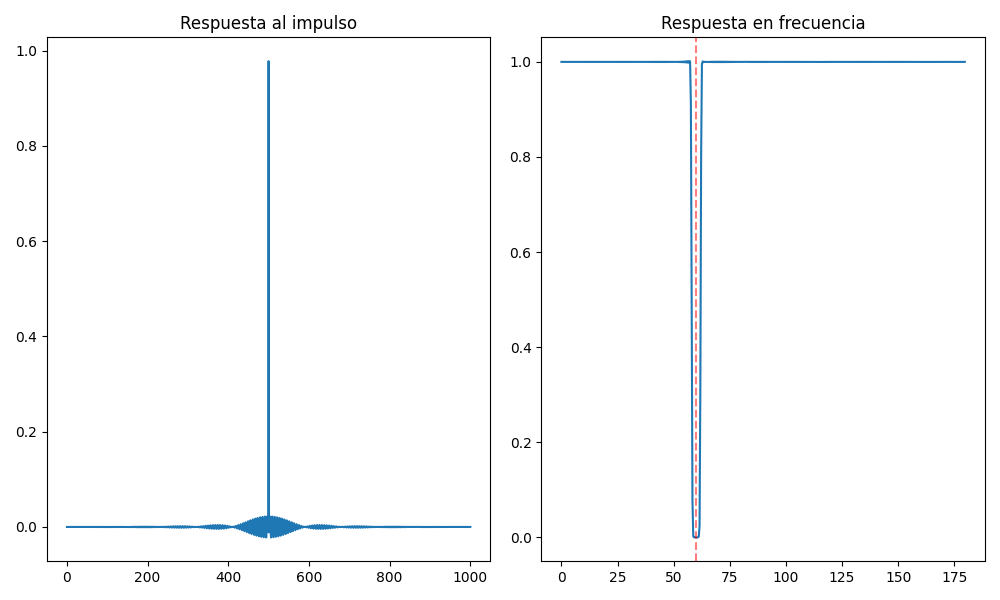

In [4]:
hA = scipy.signal.firwin(pass_zero='bandstop',fs = Fs, numtaps = 1001, cutoff = [58,62], window='hamming')
freq, H = scipy.signal.freqz(b=hA, fs= 360)
fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
ax[0].plot(hA)
ax[0].set_title('Respuesta al impulso')
ax[1].set_title('Respuesta en frecuencia')
ax[1].plot(freq,np.absolute(H))
ax[1].axvline(60, c='r', ls='--', alpha = 0.5)

**Señal Filtrada**

<IPython.core.display.Javascript object>


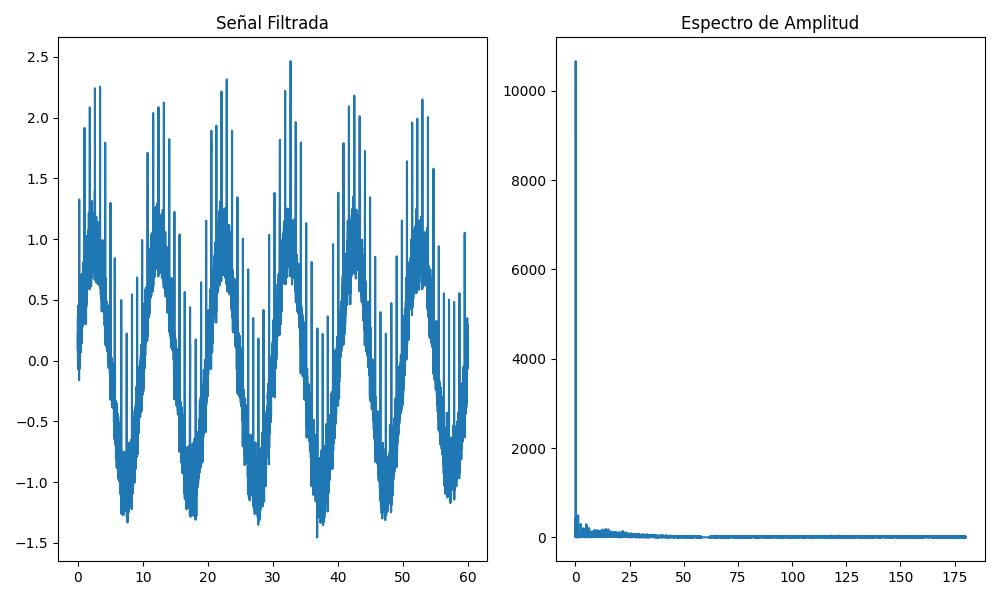

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
filtroA = scipy.signal.convolve(data,hA,'same')
Y = sfft.rfft(filtroA)
freqs = sfft.rfftfreq(n = len(filtroA), d = 1/360)
ax[0].plot(time,filtroA)
ax[0].set_title('Señal Filtrada')
ax[1].set_title('Espectro de Amplitud')
ax[1].plot(freqs,np.absolute(Y))

**Resta Señal Original - Señal Filtrada**

Al restar la señal original con la señal filtrada uno espera ver las frecuencias del ruido A, esto es debido a que las frecuencias resultantes de la resta, son las frecuencias eliminadas al utilizar el filtro

<IPython.core.display.Javascript object>


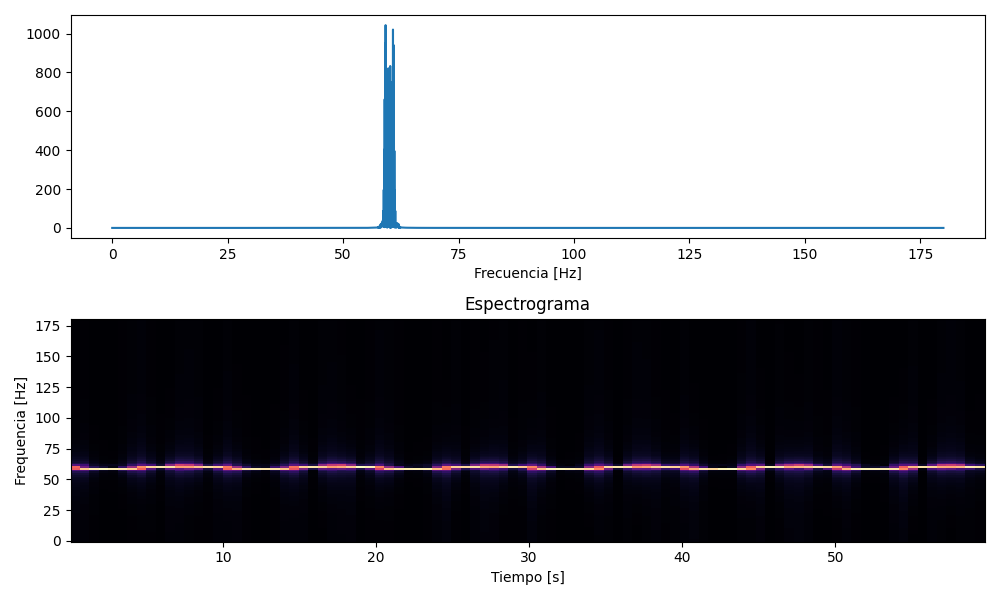

In [6]:
fig, ax = plt.subplots(2,figsize=(10, 6), tight_layout=True)
resta = data - filtroA

freq = sfft.rfftfreq(n=len(resta), d=1./Fs)
S = np.absolute(sfft.rfft(resta))
Nw = 256
freqs, times, Sxx = scipy.signal.spectrogram(resta,
                                             fs=Fs,
                                             nperseg=Nw,
                                             noverlap=None,
                                             return_onesided=True,
                                             detrend=False,
                                             mode = 'magnitude',
                                             window=('rectangular'))
ax[0].plot(freq, S); 
ax[0].set_xlabel('Frecuencia [Hz]');
ax[1].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[1].set_title("Espectrograma")
ax[1].set_ylabel('Frequencia [Hz]');
ax[1].set_xlabel('Tiempo [s]'); 


Podemos ver que la efectividad de este filtro es buena, ya que nuestro filtroA logra eliminar correctamente el Ruido A del sistema.

#### Filtro Ruido B

<IPython.core.display.Javascript object>


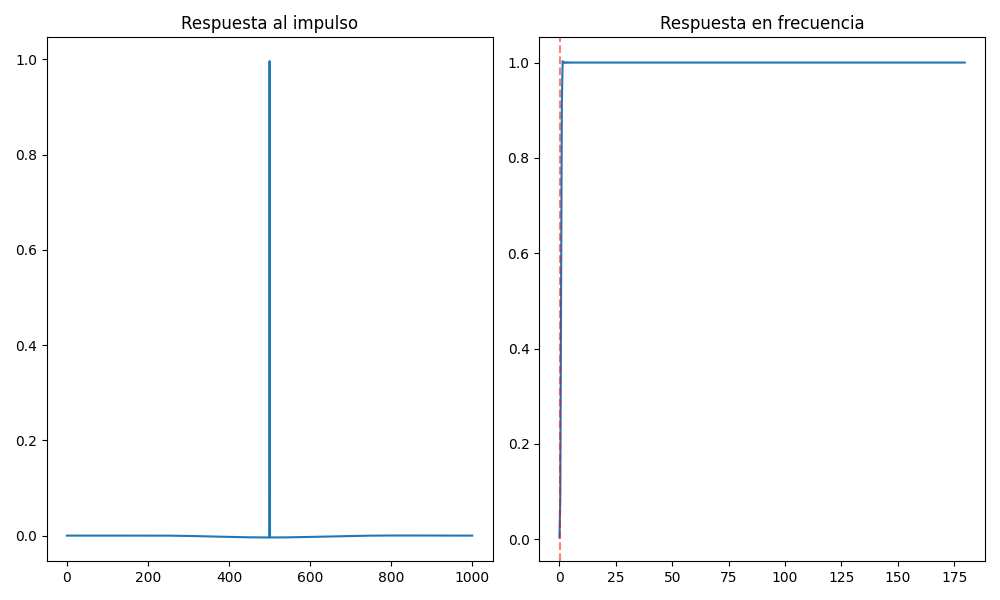

In [7]:
hB = scipy.signal.firwin(pass_zero= 'highpass', fs = Fs, numtaps = 1001, cutoff = 0.7, window='hamming')
freq, H = scipy.signal.freqz(b=hB, fs= 360)
fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
ax[0].plot(hB)
ax[0].set_title('Respuesta al impulso')
ax[1].set_title('Respuesta en frecuencia')
ax[1].plot(freq,np.absolute(H))
ax[1].axvline(0.7/2, c='r', ls='--', alpha = 0.5)

**Señal Filtrada**

<IPython.core.display.Javascript object>


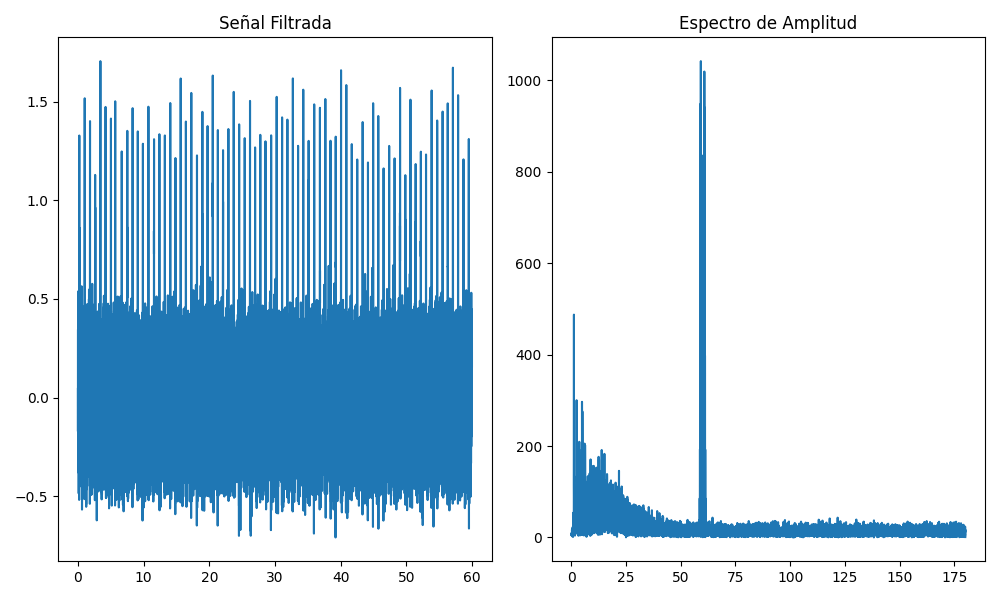

Text(0.5, 1.0, 'Espectro de Amplitud')

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
filtroB = scipy.signal.convolve(data,hB , mode='same')
Y = sfft.rfft(filtroB)
freqs = sfft.rfftfreq(n = len(filtroB), d = 1/360)
ax[0].plot(time,filtroB)
ax[1].plot(freqs,np.absolute(Y))
ax[0].set_title('Señal Filtrada')
ax[1].set_title('Espectro de Amplitud')

**Resta Señal Original - Señal Filtrada**

En este caso uno espera que al restar la señal original con la señal filtrada nos de como resultado las frecuencias eliminadas al utilizar el filtro.

<IPython.core.display.Javascript object>


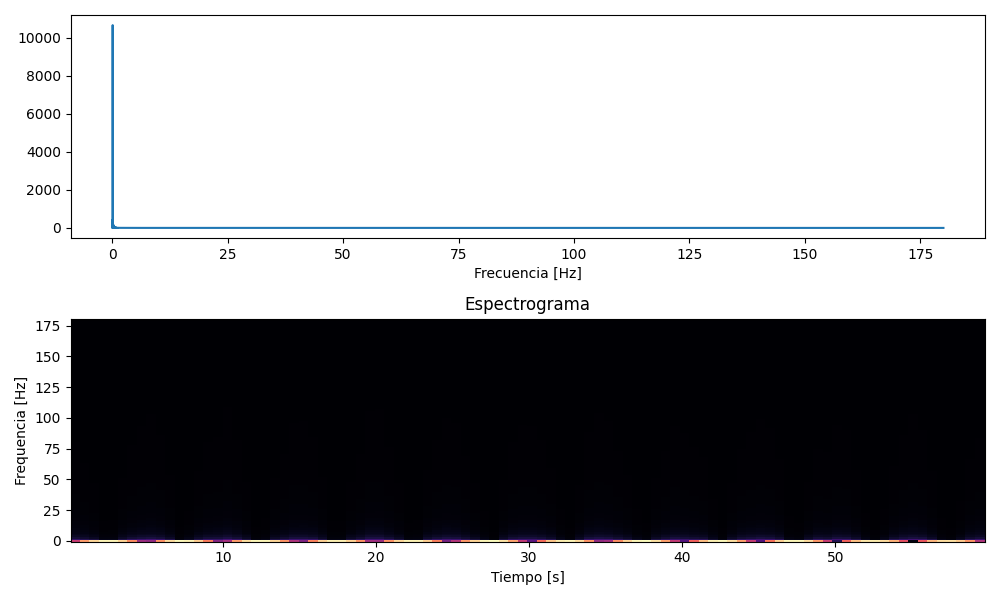

In [9]:
fig, ax = plt.subplots(2,figsize=(10, 6), tight_layout=True)
resta = data - filtroB

freq = sfft.rfftfreq(n=len(resta), d=1./Fs)
S = np.absolute(sfft.rfft(resta))
Nw = 256
freqs, times, Sxx = scipy.signal.spectrogram(resta,
                                             fs=Fs,
                                             nperseg=Nw,
                                             noverlap=None,
                                             return_onesided=True,
                                             detrend=False,
                                             mode = 'magnitude',
                                             window=('rectangular'))
ax[0].plot(freq, S); 
ax[0].set_xlabel('Frecuencia [Hz]');
ax[1].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[1].set_title("Espectrograma")
ax[1].set_ylabel('Frequencia [Hz]');
ax[1].set_xlabel('Tiempo [s]'); 

Podemos ver que este filtro es efectivo, ya que elimina los demás ruidos correctamente.

#### Filtro Ruido C

<IPython.core.display.Javascript object>


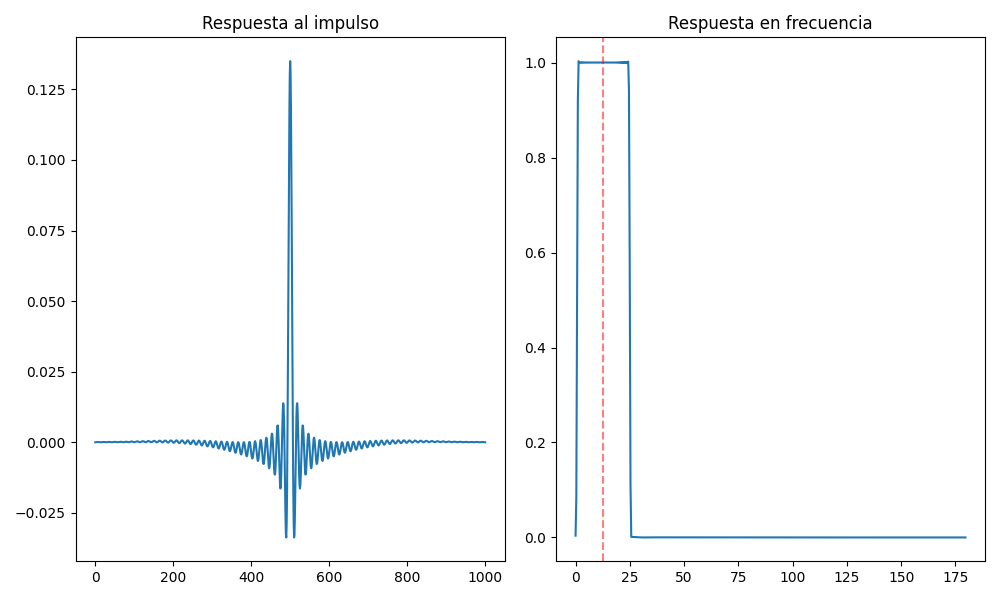

In [10]:
hC = scipy.signal.firwin(pass_zero= 'bandpass', fs = Fs, numtaps = 1001, cutoff = [0.7,25], window='hamming')
freq, H = scipy.signal.freqz(b=hC, fs= 360)
fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
ax[0].plot(hC)
ax[0].set_title('Respuesta al impulso')
ax[1].set_title('Respuesta en frecuencia')
ax[1].plot(freq,np.absolute(H))
ax[1].axvline(25.7/2, c='r', ls='--', alpha = 0.5)

**Señal Filtrada**

<IPython.core.display.Javascript object>


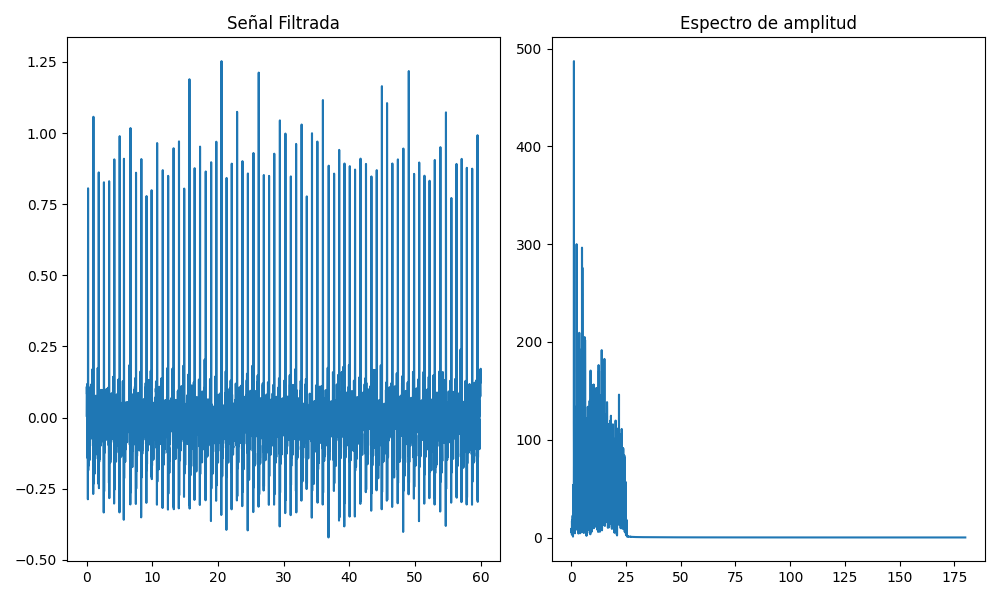

Text(0.5, 1.0, 'Espectro de amplitud')

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
filtroC = scipy.signal.convolve(data,hC, mode='same')
Y = sfft.rfft(filtroC)
freqs = sfft.rfftfreq(n = len(filtroC), d = 1/360)
ax[0].plot(time,filtroC)
ax[0].set_title('Señal Filtrada')
ax[1].plot(freqs,np.absolute(Y))
ax[1].set_title('Espectro de amplitud')

**Resta Señal Original - Señal Filtrada**

Al restar la señal filtrada a la original esperamos observar las frecuencias del ruido A y C, ya que al ser ruido blanco este se presenta en todo el sistema, por lo que el filtro que estamos aplicando no será demasiado exacto.

<IPython.core.display.Javascript object>


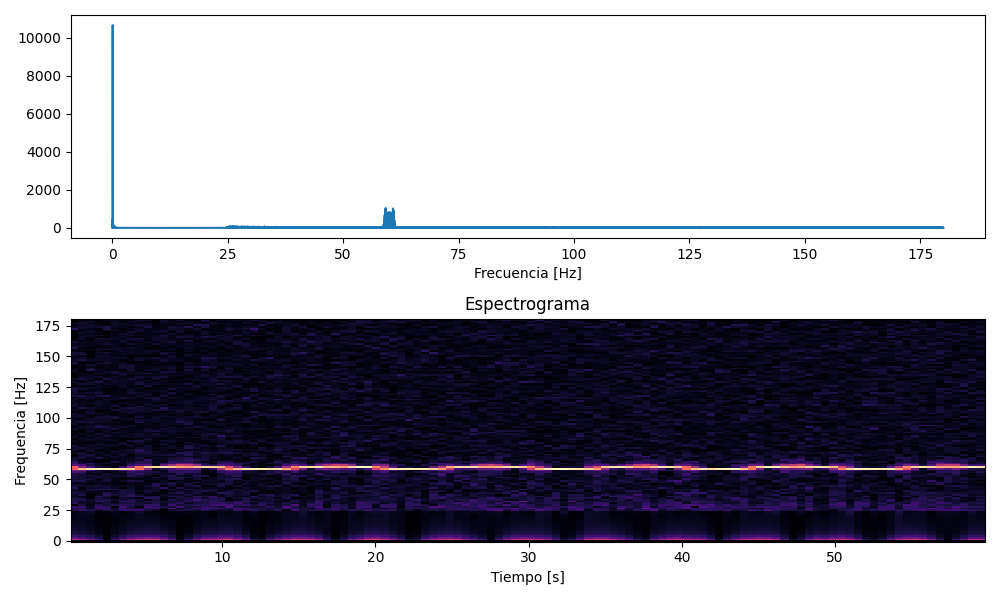

In [12]:
fig, ax = plt.subplots(2,figsize=(10, 6), tight_layout=True)
resta = data - filtroC

freq = sfft.rfftfreq(n=len(resta), d=1./Fs)
S = np.absolute(sfft.rfft(resta))
Nw = 256
freqs, times, Sxx = scipy.signal.spectrogram(resta,
                                             fs=Fs,
                                             nperseg=Nw,
                                             noverlap=512//8,
                                             mode = 'magnitude',
                                             window=('rectangular'))
ax[0].plot(freq, S); 
ax[0].set_xlabel('Frecuencia [Hz]');
ax[1].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[1].set_title("Espectrograma")
ax[1].set_ylabel('Frequencia [Hz]');
ax[1].set_xlabel('Tiempo [s]'); 

En este caso podemos decir que no es muy efectivo, ya que tal como se dijo anteriormente, este tipo de ruido se encuentra en todo el espacio.

### Señal filtrada con los 3 filtros

In [13]:
filtroA = scipy.signal.convolve(data,hA, mode='same')
filtroAB = scipy.signal.convolve(filtroA,hB, mode='same')
filtroABC = scipy.signal.convolve(filtroAB,hC, mode='same')

<IPython.core.display.Javascript object>


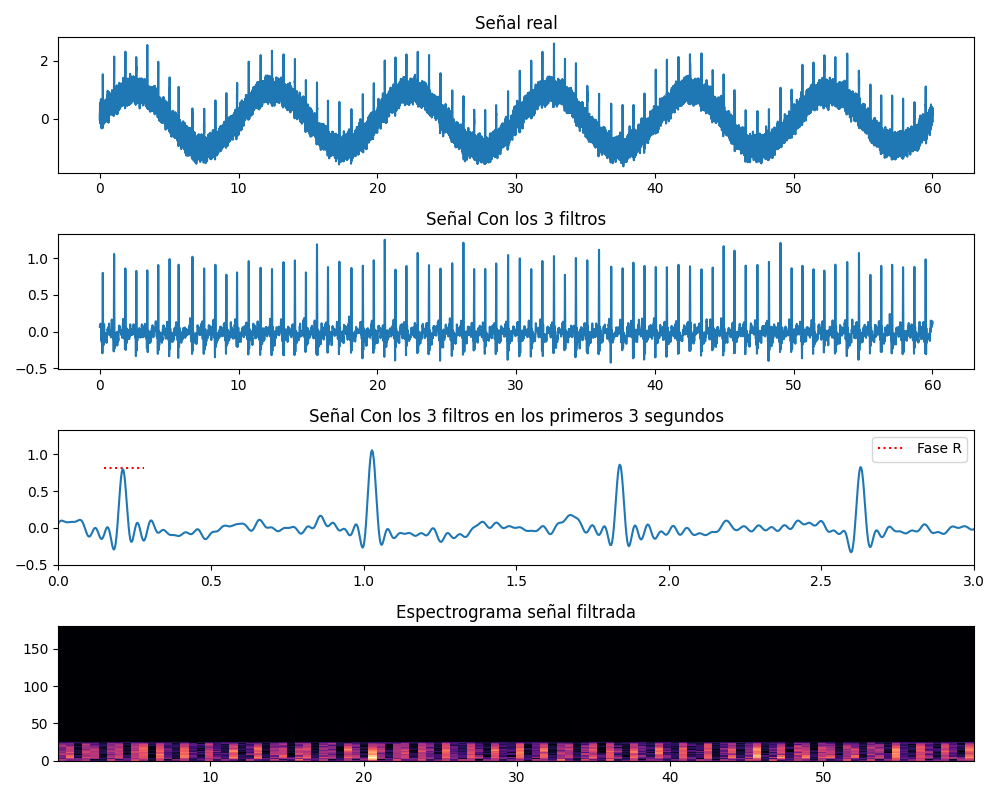

Text(0.5, 1.0, 'Espectrograma señal filtrada')

In [14]:
fig, ax = plt.subplots(4,figsize=(10, 8), tight_layout=True)
freqs, times, Sxx = scipy.signal.spectrogram(filtroABC,
                                             fs=Fs,
                                             nperseg=Nw,
                                             noverlap=512//8,
                                             mode = 'magnitude',
                                             window=('kaiser',5))
ax[1].plot(time,filtroABC)
ax[0].plot(time,data)
ax[0].set_title('Señal real')
ax[1].set_title('Señal Con los 3 filtros')
ax[2].set_title('Señal Con los 3 filtros en los primeros 3 segundos')
ax[2].plot(time,filtroABC)
ax[2].set_xlim(0,3)
ax[2].hlines(y=0.81, xmin=0.15, xmax=0.28,color='red', zorder=1, label= 'Fase R',ls=':')
ax[2].legend(loc=1);
ax[3].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[3].set_title('Espectrograma señal filtrada')

### Funcion para el tiempo RR

Para realizar esto calcularemos el máximo valor en intervalos de 0.5 segundos, si el máximo es menor o igual que 0.6 lo ignoraremos, si no se añadirá a una lista junto a su índice para así poder registrar el (X,Y) de cada R en nuestro sistema. 

In [15]:
indiceT = 0
inicio = 0
fin = 180
maxY = 0
indiceX = []
indiceY = []
for i in range(len(time)):
    if time[i] == 0.5: # esto es para obtener cada cuantos valores ocurriran cada 0.5 segundos
        indiceT = i
for i in range(120):
    maxY = max(filtroABC[inicio:fin])
    for j in range(inicio,fin):
        if filtroABC[j] ==  maxY:
            if maxY > 0.6:# esto es para no agregar a la lista valores que no pertenecen a un R, ya que al ver el grafico los R estan arriba de 0.5
                indiceY.append(maxY)
                indiceX.append(time[j])
    inicio = fin
    fin += indiceT

<IPython.core.display.Javascript object>


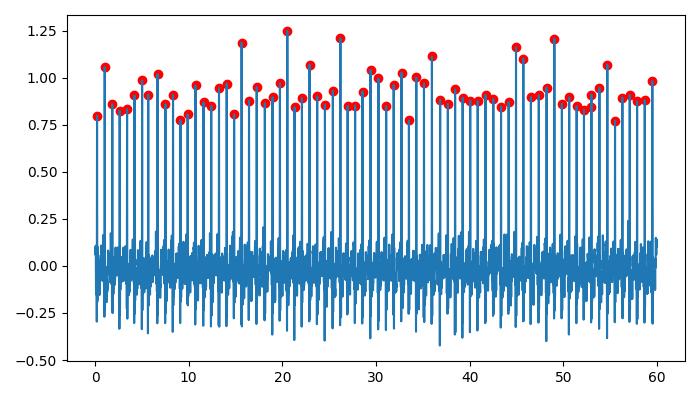

In [16]:
fig, ax = plt.subplots(1,figsize=(7, 4), tight_layout=True)
ax.plot(time,filtroABC)
ax.scatter(indiceX,indiceY,color='r')

Al ver este gráfico podemos decir que hemos podido recuperar correctamente los índices de la fase R de nuestro sistema, con esto podemos realizar la función facilmente.

In [17]:
len(indiceY)

75

In [18]:
def tiempoRR():
    tiempo = []
    Frecuencias = []
    lpm = []
    suma = 0
    for i in range(len(indiceX)-1):
        if ((indiceX[i+1]-indiceX[i]) > 0.6):
            Frecuencias.append(1/(indiceX[i+1]-indiceX[i]))
            lpm.append(60/(indiceX[i+1]-indiceX[i]))
            suma += (indiceX[i+1]-indiceX[i])
            tiempo.append(suma)
    return tiempo, Frecuencias, lpm

In [19]:
tiempo,frecuencia,lpm = tiempoRR()

<IPython.core.display.Javascript object>


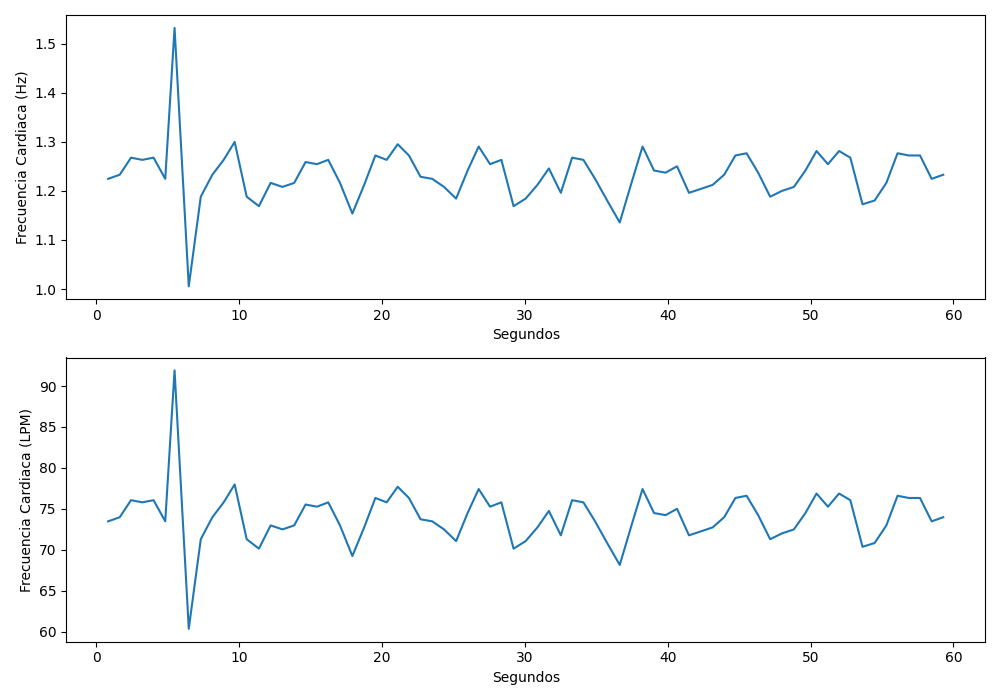

Text(0, 0.5, 'Frecuencia Cardiaca (LPM)')

In [20]:
tiempo, frecuencia, lpm = tiempoRR()
fig, ax = plt.subplots(2,figsize=(10, 7), tight_layout=True)
ax[0].plot(tiempo,frecuencia)
ax[0].set_xlabel('Segundos')
ax[0].set_ylabel('Frecuencia Cardiaca (Hz)')
ax[1].plot(tiempo,lpm)
ax[1].set_xlabel('Segundos')
ax[1].set_ylabel('Frecuencia Cardiaca (LPM)')

Dado que una persona normal tiene entre 60-100 latidos por minuto, podemos decir que el sujeto al que le realizaron el electrocardiograma se encuentra dentro del rango normal, ya que como podemos apreciar en el gráfico anterior, la frecuencia cardiaca de este individuo siempre se encuntra en el rango aceptable.

### Extra

#### Audio sin filtrar

In [21]:
Audio(data=data, rate = 720)

#### Audio con filtros

In [22]:
Audio(data=filtroABC, rate = 720)

Al reproducir el audio nos damos cuenta que el paciente al que le tomaron el electrocardiograma 

**No sé qué querías decir**

##  Filtrado IIR

### Descripción de filtro IIR

Un filtro IIR a diferencia de los FIR, tiene una respuesta infinita al impulso y se caracteriza por tener una retroalimentación de la señal de salida. Es un filtro recursivo, donde la salida es función de la entrada y de las salidas anteriores.

In [94]:
scipy.signal.iirfilter?

**scipy.signal.iirfilter**: 

**Argumentos**:

- N: Orden del filtro
- Wn: Frecuencias de corte
- btype (opcional): Tipo de filtro, valor por defecto es 'bandpass'
- ftype (opcional): Tipo de filtro IIR a diseñar (familia)
        - Butterworth   : 'butter'
        - Chebyshev I   : 'cheby1'
        - Chebyshev II  : 'cheby2'
        - Cauer/elliptic: 'ellip'
        - Bessel/Thomson: 'bessel'
- output (opcional): Tipo de salida, valor por defecto es 'ba'
- fs (opcional): Frecuencia de muestreo del sistema digital 

**Salida**:

- b, a: Numerador y denominador polinomiales del filtro IIR (output='ba')
- z, p, k: Ceros, polos, y ganancia de la función de transferencia del filtro IIR
- sos: Representación de secciones de segundo orden del filtro IIR

### Filtros

#### Estimador de mínimo orden

In [89]:
def minOrder(iir, fir):
    N = np.amin([len(iir), len(fir)])
    s1 = np.sum(np.power(iir[:N] - fir[:N], 2))
    ym = np.zeros(N)
    for i in range(N):
        ym[i] = np.sum(fir[:i])/(i+1)
    s2 = np.sum(np.power(fir[:N] - ym[:N], 2))
    print('{} < {}'.format(s1, 0.01*s2))
    return s1, (s1 < (0.01*s2))

#### Filtro IIR

**Se hace un cambio en la función para aplicar los filtros, se cambia lfilter por filtfilt con el fin de poder eliminar el delay inherente a lfilter y poder evaluar de mejor forma el filtro con la función minOrder()**

##### Condición Inicial

In [136]:
N = 1
fc = [[58,62], 0.7, 25]
wn = [[fc[0][0]/Fs, fc[0][1]/Fs], fc[1]/Fs, fc[2]/Fs]
##Filtro A
b, a = scipy.signal.iirfilter(N=N, Wn= wn[0], fs=1,
                                ftype='butter', btype='bandstop', output='ba')
iirA = scipy.signal.filtfilt(b, a, data)

##Filtro AB
b2, a2 = scipy.signal.iirfilter(N=N, Wn=wn[1], fs=1,
                                ftype='butter', btype='highpass', output='ba')
iirAB = scipy.signal.filtfilt(b2, a2, iirA)

##Filtro ABC
b3, a3 = scipy.signal.iirfilter(N=N, Wn=wn[2], fs=1,
                                ftype='butter', btype='lowpass', output='ba')
iirABC = scipy.signal.filtfilt(b3, a3, iirAB)


##### Estimando mejor N y diseñando el filtro correspondiente

In [137]:
ecm, m = minOrder(iirABC, filtroABC)
while not m and (ecm < 10**2):
    N += 1
    
    ##Filtro A
    b, a = scipy.signal.iirfilter(N=N, Wn= wn[0], fs=1,
                                ftype='butter', btype='bandstop', output='ba')
    iirA = scipy.signal.filtfilt(b, a, data)

    ##Filtro AB
    b2, a2 = scipy.signal.iirfilter(N=N, Wn=wn[1], fs=1,
                                    ftype='butter', btype='highpass', output='ba')
    iirAB = scipy.signal.filtfilt(b2, a2, iirA)
    
    ##Filtro ABC
    b3, a3 = scipy.signal.iirfilter(N=N, Wn=wn[2], fs=1,
                                    ftype='butter', btype='lowpass', output='ba')
    iirABC = scipy.signal.filtfilt(b3, a3, iirAB)
    
    ecm, m = minOrder(iirABC, filtroABC)
print('Best Order: ', N-1)

55.1917822644718 < 5.720377520500233
27.38970353412594 < 5.720377520500233
17.84913917492979 < 5.720377520500233
13.187495997950254 < 5.720377520500233
10.27285524915277 < 5.720377520500233
8.422387524658475 < 5.720377520500233
7.726692771885732 < 5.720377520500233
6.810299817236533e+145 < 5.720377520500233
Best Order:  7


#### Gráficos

In [122]:
N=7
##Filtro A
b, a = scipy.signal.iirfilter(N=N, Wn= wn[0], fs=1,
                                ftype='butter', btype='bandstop', output='ba')
iirA = scipy.signal.filtfilt(b, a, data)

##Filtro AB
b2, a2 = scipy.signal.iirfilter(N=N, Wn=wn[1], fs=1,
                                ftype='butter', btype='highpass', output='ba')
iirAB = scipy.signal.filtfilt(b2, a2, iirA)

##Filtro ABC
b3, a3 = scipy.signal.iirfilter(N=N, Wn=wn[2], fs=1,
                                ftype='butter', btype='lowpass', output='ba')
iirABC = scipy.signal.filtfilt(b3, a3, iirAB)

Dado que en el paso anterior se comprueba que el ECM del filtro IIR no llega a ser menor al 1% de la varianza del filtro FIR, usamos el orden que nos da el menor ECM, que vendría siendo N=7. Con este orden realizamos los siguientes gráficos:

##### Respuesta al impulso de los filtros IIR

<IPython.core.display.Javascript object>


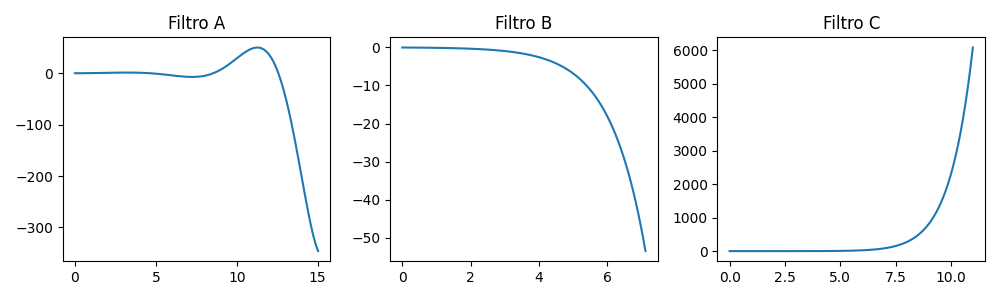

Text(0.5, 1.0, 'Filtro C')

In [126]:
fig, ax = plt.subplots(1,3,figsize=(10, 3), tight_layout=True)

t,y = scipy.signal.impulse(scipy.signal.lti(b,a))
t2,y2 = scipy.signal.impulse(scipy.signal.lti(b2,a2))
t3,y3 = scipy.signal.impulse(scipy.signal.lti(b3,a3))

ax[0].plot(t, y)
ax[0].set_title('Filtro A')

ax[1].plot(t2, y2)
ax[1].set_title('Filtro B')

ax[2].plot(t3,y3)
ax[2].set_title('Filtro C')

##### Respuesta a la frecuencia de los filtros IIR

<IPython.core.display.Javascript object>


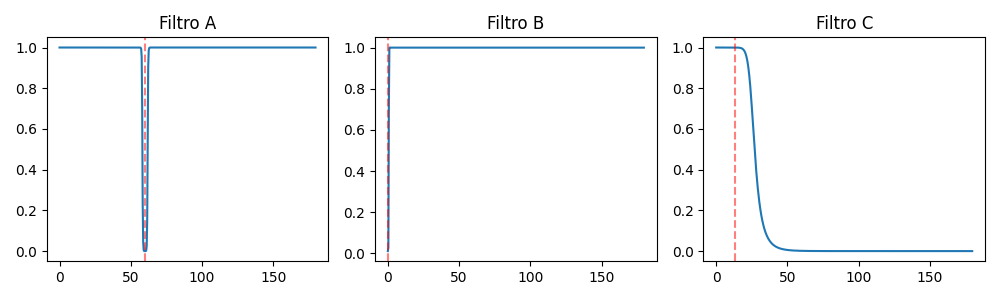

Text(0.5, 1.0, 'Filtro C')

In [129]:
fig, ax = plt.subplots(1,3,figsize=(10, 3), tight_layout=True)

freq_iirA, response_iirA = scipy.signal.freqz(b, a, fs=Fs)
freq_iirB, response_iirB = scipy.signal.freqz(b2, a2, fs=Fs)
freq_iirC, response_iirC = scipy.signal.freqz(b3, a3, fs=Fs)

ax[0].plot(freq_iirA, np.absolute(response_iirA))
ax[0].axvline(60, c='r', ls='--', alpha = 0.5)
ax[0].set_title('Filtro A')

ax[1].plot(freq_iirB, np.absolute(response_iirB))
ax[1].axvline(0.7/2, c='r', ls='--', alpha = 0.5)
ax[1].set_title('Filtro B')

ax[2].plot(freq_iirC, np.absolute(response_iirC))
ax[2].axvline(25.7/2, c='r', ls='--', alpha = 0.5)
ax[2].set_title('Filtro C')

##### Señal filtrada

<IPython.core.display.Javascript object>


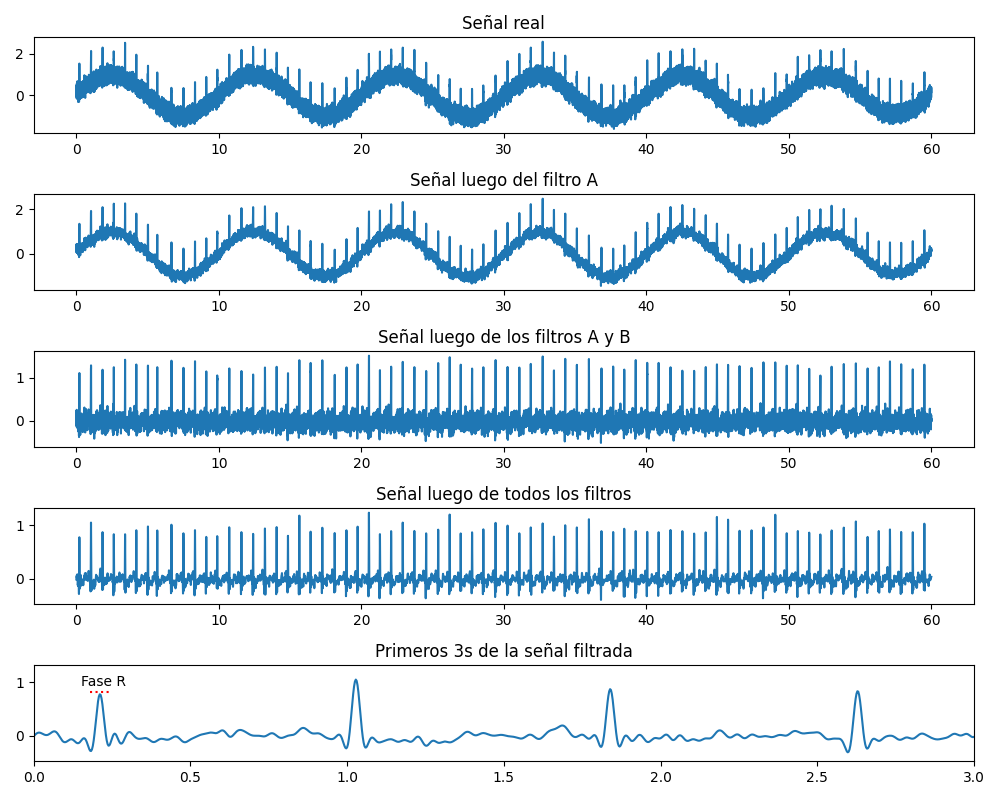

Text(0.5, 1.0, 'Primeros 3s de la señal filtrada')

In [134]:
fig, ax = plt.subplots(5,figsize=(10, 8), tight_layout=True)

ax[0].plot(time,data)
ax[0].set_title('Señal real')

ax[1].plot(time,iirA)
ax[1].set_title('Señal luego del filtro A')

ax[2].plot(time,iirAB)
ax[2].set_title('Señal luego de los filtros A y B')

ax[3].plot(time, iirABC)
ax[3].set_title('Señal luego de todos los filtros')

ax[4].plot(time,iirABC)
ax[4].set_xlim(0,3)
ax[4].hlines(y=0.81, xmin=0.18, xmax=0.24,color='red', zorder=1, label= 'Fase R',ls=':')
plt.text(0.15, 1, 'Fase R', ha ='left', va ='center')
ax[4].set_title('Primeros 3s de la señal filtrada')



#### Audio con filtro IIR

In [135]:
Audio(data=iirABC, rate = 720)

## Conclusión